# Heavy rainfall


```{glue:figure} 95_fig
:scale: 60%
:align: center
```

## Setup

First, we need to import all the necessary libraries. Some of them are specifically developed to handle the download and plotting of the data and are hosted at the [indicators set-up repository](https://github.com/lauracagigal/indicators_setup) in GitHub

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import os.path as op
import sys
import folium

from myst_nb import glue 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../../../../indicators_setup")
from ind_setup.plotting_int import plot_timeseries_interactive
from ind_setup.plotting import plot_bar_probs
from ind_setup.colors import get_df_col
from ind_setup.core import fontsize
from ind_setup.tables import plot_df_table, table_rain_a_summary


sys.path.append("../../../functions")
from data_downloaders import GHCN


from data_downloaders import GHCN, download_oni_index
from ind_setup.plotting_int import plot_oni_index_th
from ind_setup.plotting import plot_bar_probs_ONI, add_oni_cat
import df2img

In [2]:
country = 'Palau'
vars_interest = ['PRCP']

### Get Data

In [3]:
update_data = False
path_data = "../../../data"
path_figs = "../../../matrix_cc/figures"

In [4]:
if update_data:
    df_country = GHCN.get_country_code(country)
    print(f'The GHCN code for {country} is {df_country["Code"].values[0]}')

    df_stations = GHCN.download_stations_info()
    df_country_stations = df_stations[df_stations['ID'].str.startswith(df_country.Code.values[0])]
    print(f'There are {df_country_stations.shape[0]} stations in {country}')

### Obervations from Koror Station

https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/doc/GHCND_documentation.pdf

The data used for this analysis comes from the GHCN (Global Historical Climatology Network)-Daily database. <br>
This a database that addresses the critical need for historical daily temperature, precipitation, and snow records over global land areas. GHCN-Daily is a
composite of climate records from numerous sources that were merged and then subjected to a suite of
quality assurance reviews. The archive includes over 40 meteorological elements including temperature daily maximum/minimum, temperature at observation time,
precipitation and more.

In [5]:
if update_data:
    GHCND_dir = 'https://www.ncei.noaa.gov/data/global-historical-climatology-network-daily/access/'
    id = 'PSW00040309' # Koror Station
    dict_prcp = GHCN.extract_dict_data_var(GHCND_dir, 'PRCP', df_country_stations.loc[df_country_stations['ID'] == id])[0]
    data = dict_prcp[0]['data']#.dropna()
    data.to_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))
else:
    data = pd.read_pickle(op.join(path_data, 'GHCN_precipitation.pkl'))

## Analysis

### Days over 95 threshold

To have a metric of the changes in the extreme rainfall regime, the number of days over the 95 percentile is analyzed in the following plot

In [6]:
prcentile = 95
threshold = np.round(np.percentile(data['PRCP'].dropna(), prcentile), 2)
print(f'Threshold of {threshold}mm')
data['wet_day_t'] = np.where(data['PRCP'] > threshold, 1, np.where((np.isnan(data['PRCP'])==True), np.nan, 0))

Threshold of 45.5mm


In [7]:
data_2 = data.loc[data['wet_day_t'] == 1][['PRCP']]
data_over_th = data_2.groupby(data_2.index.year).count()
data_over_th.index = pd.to_datetime(data_over_th.index, format = '%Y')


In [8]:
data_over_th['PRCP_below'] = 365 - data_over_th['PRCP'].values

In [9]:
dict_plot = [{'data' : data_over_th, 'var' : 'PRCP', 'ax' : 1, 'label':f'Number of days over threshold: {threshold}mm'},]

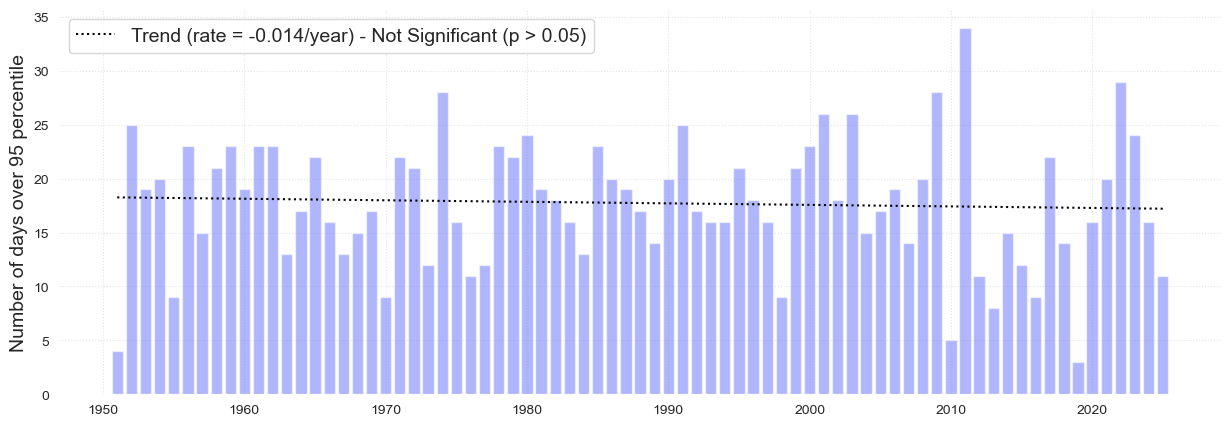

In [10]:
fig, ax = plot_bar_probs(x = data_over_th.index.year, y = data_over_th['PRCP'].values, trendline = True,
               figsize = (15, 5), y_label = f'Number of days over {prcentile} percentile')

plt.savefig(op.join(path_figs, 'F7b_Wet_days_95p.png'), dpi=300, bbox_inches='tight')
glue('95_fig', fig, display=False)

### Table
Table sumarizing different metrics of the data analyzed in the plots above

In [11]:
# df = table_rain_a_summary(data)
# fig = plot_df_table(df.T, figsize = (600, 350),)